In [2]:
# Here is my implementation. I found inspiration from the following implementation
# of two digit addition on the web. https://pylon-lib.github.io/notebooks/mnist_addition

# The goal of the referenced implementation was to use the summation as the target and define the objective
# loss function based on that. They would train on pairs and the summation and then test against the single
# digits. Showing that training on pairs and summation can result in accurate predictions of single digits.
# It showed that you can effectively train on sequence and summation to accurately predict single digits.

# Given that our sequence was much larger, I made an assumption that the loss would grow along with the
# increase in sequence size but that inversely the loss would be reduced if you trained on images and their
# target in order to predict summation. Given that with the images and targets we have more closely related
# data, we can achieve a more granular result and better learn the relationships with the network.

# Also, effectively if you can predict the digits with high percision, then it will lead to accurate summation.

# I utilize a convolutional layer for our images, a 'classifier layer' for features, a 'sum it up layer' for
# the sum and a parent layer that calls all others. A note regarding the sum it up layer and the calculated loss
# for the sums, these are not back prop because it doesn;t have any trainable paramenters. This was done, just for
# the summation and visibility of the loss decreasing as we better learned the digits.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

# Parameters
sequence_length = 100    # Do not change this
torch.manual_seed(45662) # Do not change this
batch_size = 64
num_epochs = 5
learning_rate = 0.001

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Custom Dataset for Sequences
class MNISTSequences(Dataset):
    def __init__(self, mnist_dataset, seq_length=3):
        self.mnist_dataset = mnist_dataset
        self.seq_length = seq_length

    def __len__(self):
        return len(self.mnist_dataset) // self.seq_length

    def __getitem__(self, idx):
        images = []
        labels = []
        sum_labels = 0
        for i in range(self.seq_length):
            image, label = self.mnist_dataset[idx * self.seq_length + i]
            images.append(image)
            labels.append(label)
            sum_labels += label
        return torch.stack(images), torch.tensor(labels), torch.tensor(sum_labels)

train_seq_dataset = MNISTSequences(train_dataset, sequence_length)
test_seq_dataset = MNISTSequences(test_dataset, sequence_length)

train_loader = DataLoader(train_seq_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_seq_dataset, batch_size=batch_size, shuffle=False)

# Model
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride = 1, padding = 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride = 1, padding = 2)
        self.fc1 = nn.Linear(3136, 1024)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 3136)
        x = F.relu(self.fc1(x))
        return x

class NumClassifier(nn.Module):
    def __init__(self):
        super(NumClassifier, self).__init__()
        self.fc2 = nn.Linear(1024,10)

    def forward(self,x):
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

class SumItUp(nn.Module):
    def forward(self, x):
        _, prednums = torch.max(x,2)
        return torch.sum(prednums, dim=1)

class PutAllTogether(nn.Module):
    def __init__(self):
        super(PutAllTogether, self).__init__()
        self.features = CNet()
        self.classify = NumClassifier()
        self.sums = SumItUp()

    def forward(self, x):
        batch_size, seq_length, _, height, width = x.size()
        x = x.view(batch_size * seq_length, 1, height, width)
        x = self.features(x)
        x = self.classify(x)
        x = x.view(batch_size, seq_length, -1)
        summout = self.sums(x)
        return x, summout

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PutAllTogether().to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

classloss = nn.CrossEntropyLoss()
sumcriterion = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels, sums) in enumerate(train_loader):
        images, labels, sums = images.to(device), labels.to(device).view(-1), sums.to(device).float()
        optimizer.zero_grad()
        output, predsums = model(images)
        closs = classloss(output.view(-1,10), labels)
        sloss = sumcriterion(predsums, sums)
        closs.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Sum Loss: {sloss.item()}, Objective Function Loss (Digit Classifier): {closs.item()}')

model.eval()
for i, (images,labels,sums) in enumerate(test_loader):
    images, labels, sums = images.to(device), labels.to(device), sums.to(device)
    output, predicted_sums = model(images)
    _, predicted_labels = torch.max(output,2)
    predicted_sums = predicted_sums
    for j in range(images.size(0)):
        print(f"Batch {i}, Sequence {j}: Predicted Sum: {predicted_sums[j].item()}, Actual Sum: {sums[j].item()}")
        print(" ")
        print(f"Predicted Digits: {predicted_labels[j].cpu().numpy()}")
        print(f"Actual Digits: {labels[j].cpu().numpy()}")
        print(" ")
        print("---")
        print(" ")

100%|██████████| 9912422/9912422 [00:00<00:00, 140490758.84it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 57492023.65it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 55101874.71it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4713144.18it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 0, Sum Loss: 1611.666748046875, Objective Function Loss (Digit Classifier): 0.6327589154243469
Epoch 1, Sum Loss: 210.4166717529297, Objective Function Loss (Digit Classifier): 0.3267630934715271
Epoch 2, Sum Loss: 220.9166717529297, Objective Function Loss (Digit Classifier): 0.23552297055721283
Epoch 3, Sum Loss: 82.75, Objective Function Loss (Digit Classifier): 0.14360137283802032
Epoch 4, Sum Loss: 55.79166793823242, Objective Function Loss (Digit Classifier): 0.12207519263029099
Batch 0, Sequence 0: Predicted Sum: 436, Actual Sum: 434
 
Predicted Digits: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9]
Actual Digits: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4

In [5]:
model.eval()
for i, (images, labels, sums) in enumerate(test_loader):
    images, labels, sums = images.to(device), labels.to(device).view(-1), sums.to(device).float()
    output, predicted_sums = model(images)
    closs = classloss(output.view(-1,10), labels)
    sloss = sumcriterion(predicted_sums, sums)
    print(f'Test Loss: {sloss.item()}, Test Objective Function Loss: {closs.item()}')

Test Loss: 65.046875, Test Objective Function Loss: 0.12388873845338821
Test Loss: 45.11111068725586, Test Objective Function Loss: 0.06377289444208145


In [6]:
from torchviz import make_dot

outputs = model(images)

make_dot(outputs, params = dict(list(model.named_parameters()))).render("Network Architecture", format='png')

'Network Architecture.png'

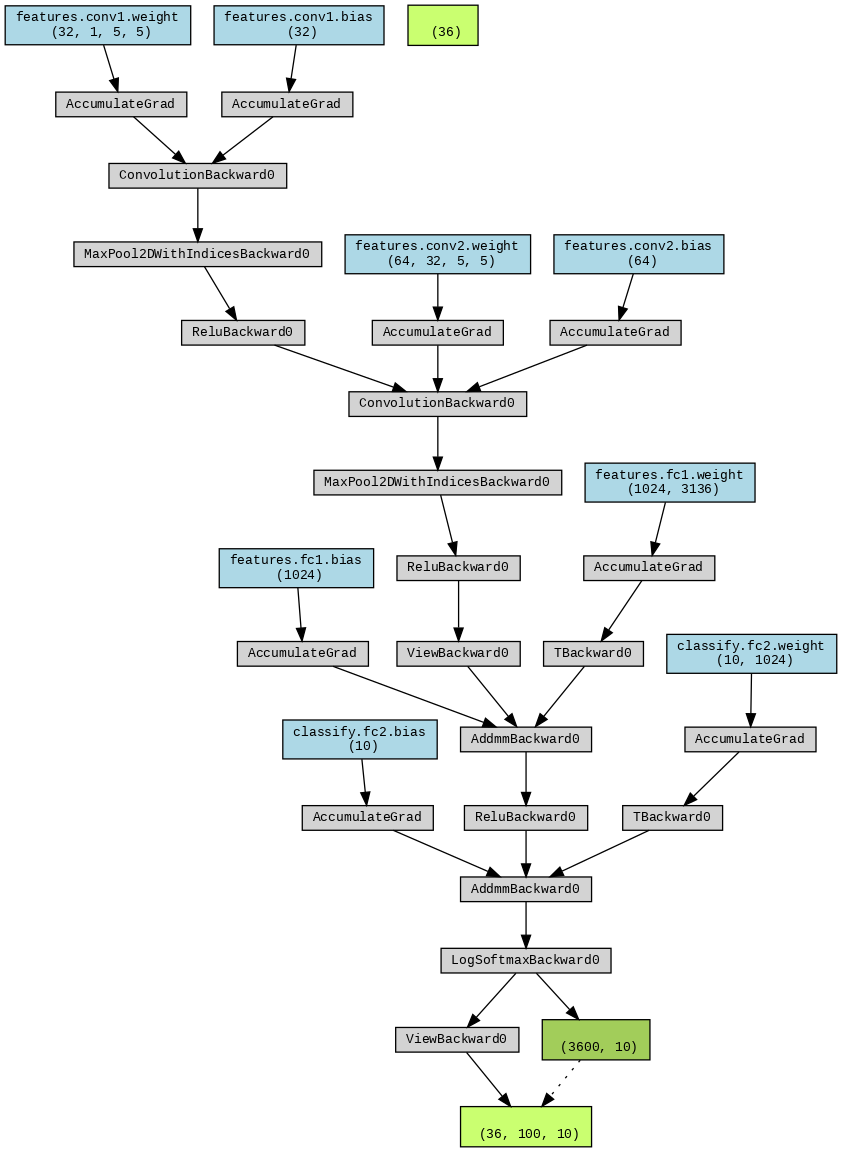

In [7]:
from IPython.display import Image
Image('Network Architecture.png')